# Data Loader
This is a data loader for reblur project

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os.path
import random
import torchvision.transforms as transforms
import torch
import sys
#sys.path.append("./DeblurGAN")
sys.path.append("./DeblurGAN/data")
from base_dataset import BaseDataset
from image_folder import make_dataset
from PIL import Image

plt.ion()   # interactive mode

The sample of our dataset is formed like a dict {'image1': (t-2)th image, 'image2': (t-1)th image, 'image3': (t)th image, 'image3': (t+1)th image, 'image4': (t+2)th image, 'imageSharp': sharp image of (t)th image}

In [2]:
class deblurDataSet(Dataset):
    """Deblur dataset."""

    def __init__(self, root_dir, blur_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            blur_file("blur" or "blur_gamma"): denote two different types of blur
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.blur_file = blur_file
        self.transform = transform
        self.folders = sorted(os.listdir(root_dir))
        foldersLen = []
        foldersStart = []
        for folder in self.folders:
            tempList = sorted(os.listdir(os.path.join(root_dir, folder, blur_file)))
            foldersLen.append(len(tempList))
            foldersStart.append(int(tempList[0].split('.')[0]))
        self.foldersLen = foldersLen
        self.foldersStart = foldersStart
        

    def __len__(self):
        return sum(self.foldersLen) - 4 * len(self.foldersLen)

    def __getitem__(self, offset):
        images = []
        sample = {}
        cnt = 0
        offset = offset + 1
        while offset > 0:
            offset = offset - self.foldersLen[cnt] + 4
            cnt = cnt + 1
        cnt = cnt - 1
        offset = offset + self.foldersLen[cnt] - 5
        for index in range(5):
            img_name = os.path.join(self.root_dir, self.folders[cnt], self.blur_file
                                ,str(self.foldersStart[cnt]+offset+index).zfill(6)+".png")
            images.append(io.imread(img_name))
            sample['image'+str(index)] = images[index]
        label_name = os.path.join(os.path.join(self.root_dir, self.folders[cnt], "sharp"
                                ,str(self.foldersStart[cnt]+offset+2).zfill(6)+".png"))
        sample['label'] = io.imread(label_name)
        if self.transform:
            sample = self.transform(sample)

        return sample 

class GoproDataloader():
    
        def __init__(self, root_dir, blur_file, transform=None):

        
            self.root_dir = root_dir
            self.blur_file = blur_file
            self.transform = transform
            self.folders = sorted(os.listdir(root_dir))
            foldersLen = []
            foldersStart = []
            for folder in self.folders:
                tempList = sorted(os.listdir(os.path.join(root_dir, folder, blur_file)))
                foldersLen.append(len(tempList))
                foldersStart.append(int(tempList[0].split('.')[0]))
            self.foldersLen = foldersLen
            self.foldersStart = foldersStart
        
        def __getitem__(self, offset):
            
            images = []
            sample = {}
            cnt = 0
            offset = offset + 1
            while offset > 0:
                offset = offset - self.foldersLen[cnt] + 4
                cnt = cnt + 1
            cnt = cnt - 1
            offset = offset + self.foldersLen[cnt] - 5
            #for index in range(5):
            img_name = os.path.join(self.root_dir, self.folders[cnt], self.blur_file
                                ,str(self.foldersStart[cnt]+offset).zfill(6)+".png")
            img=io.imread(img_name)
            images.append(io.imread(img_name))
            #sample['image'+str(index)] = images[index]
            label_name = os.path.join(os.path.join(self.root_dir, self.folders[cnt], "sharp"
                                    ,str(self.foldersStart[cnt]+offset+2).zfill(6)+".png"))
            label=io.imread(label_name)
            sample['label'] = io.imread(label_name)
            if self.transform:
                sample = self.transform(sample)

            return img, label
        
        
        def __len__(self):
            pass

Transform function

In [3]:
class Normalize(object):
    """normalize the images to [-1,1]."""

    def __call__(self, sample):

        return {key:(sample[key].astype(float) - 128)/128 for key in sample}



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return {key:torch.from_numpy(sample[key].transpose((2, 0, 1))) for key in sample}

Load dataSet

In [4]:
norm = Normalize()
toTensor = ToTensor()
dataset = deblurDataSet("/scratch/user/jiangziyu/data/GOPRO_Large/train/",
                        "blur",transforms.Compose([norm,toTensor]))
print(len(dataset))
print(dataset.foldersLen)

2015
[100, 75, 150, 80, 100, 48, 110, 100, 60, 100, 100, 100, 100, 100, 100, 80, 100, 100, 100, 100, 100, 100]


Transform data and draw it

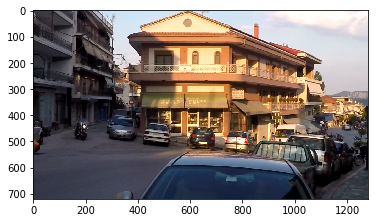

In [5]:
g= GoproDataloader("/scratch/user/jiangziyu/data/GOPRO_Large/train/",
                        "blur",transforms.Compose([norm,toTensor]))
i,l= g.__getitem__(7)


plt.imshow(l)

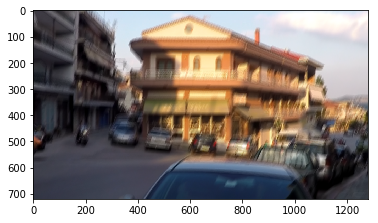

In [6]:
(plt.imshow(i))

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


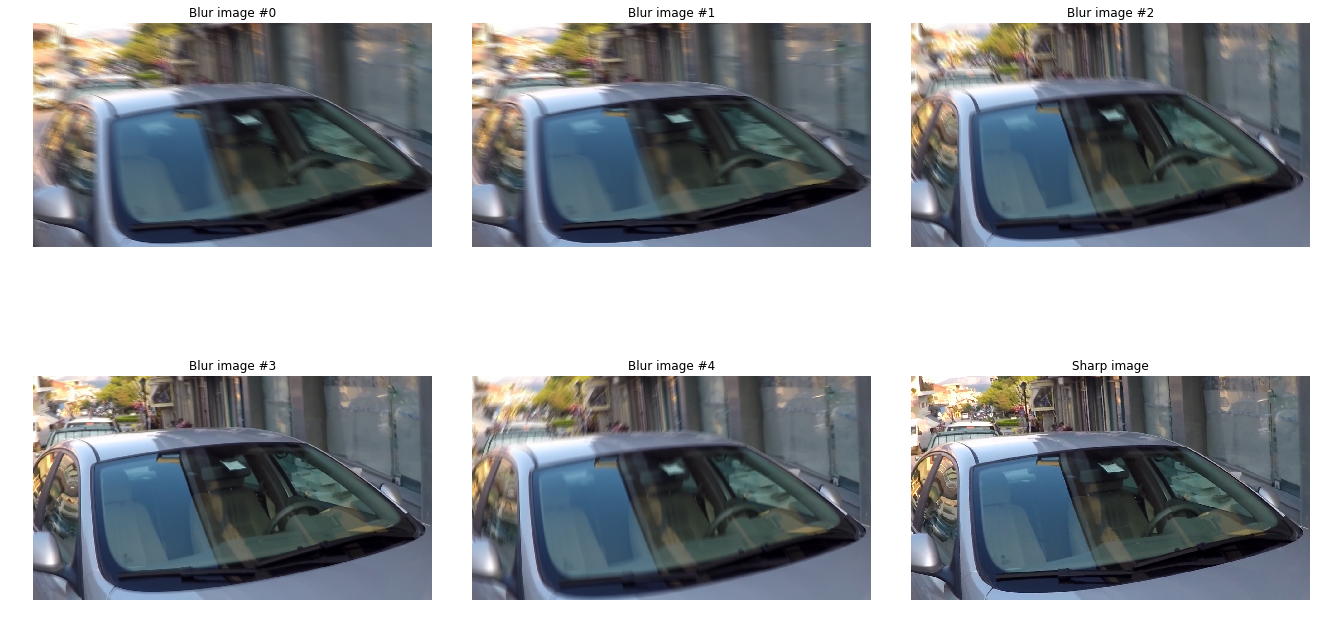

In [7]:
sample = dataset[80]
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for i in range(5):
    image = ((sample['image'+str(i)].numpy()+1)/2).transpose((1, 2, 0))
    ax = plt.subplot(2, 3, i + 1)
    print(image.shape)
    
    ax.set_title('Blur image #{}'.format(i))
    ax.axis('off')
    plt.imshow(image)
    
ax = plt.subplot(2, 3, 6)
plt.tight_layout()
ax.set_title('Sharp image')
ax.axis('off')
plt.imshow(((sample['label'].numpy()+1)/2).transpose((1, 2, 0)))
    

DataLoader

In [8]:

#dataloader = DataLoader(dataset, batch_size=4,
#                        shuffle=True, num_workers=4)

# DeblurGAN
* import the deblurGAN with its weights

In [9]:
import sys
sys.path.append('./DeblurGAN')
from torch.autograd import Variable
from collections import OrderedDict
import DeblurGAN.util.util as util
from DeblurGAN.models.base_model import BaseModel
from DeblurGAN.options.test_options import TestOptions
from DeblurGAN.models import networks

In [10]:
sys.argv = ['test.py', '--dataroot', '/scratch/user/jiangziyu/data/GOPRO_for_reblurGAN/', '--model', 'test', '--dataset_mode', 'single', '--learn_residual', '--resize_or_crop', 'scale_width']
opt = TestOptions().parse()
opt.nThreads = 1   # test code only supports nThreads = 1
opt.batchSize = 1  # test code only supports batchSize = 1
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip

['test.py', '--dataroot', '/scratch/user/jiangziyu/data/GOPRO_for_reblurGAN/', '--model', 'test', '--dataset_mode', 'single', '--learn_residual', '--resize_or_crop', 'scale_width']
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
dataroot: /scratch/user/jiangziyu/data/GOPRO_for_reblurGAN/
dataset_mode: single
display_id: 1
display_port: 8097
display_single_pane_ncols: 0
display_winsize: 256
fineSize: 256
gan_type: wgan-gp
gpu_ids: [0]
how_many: 5000
input_nc: 3
isTrain: False
learn_residual: True
loadSizeX: 640
loadSizeY: 360
max_dataset_size: inf
model: test
nThreads: 2
n_layers_D: 3
name: experiment_name
ndf: 64
ngf: 64
no_dropout: False
no_flip: False
norm: instance
ntest: inf
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: False
which_direction: AtoB
which_epoch: latest
which_model_netD: basic
which_model_netG: resnet_9blocks
-------------- End ----------------


### Create data loader

In [11]:
# dataset=AlignedDataset()
# dataloader = DataLoader(dataset, batch_size=4,
#                        shuffle=True, num_workers=4)

def CreateDataLoader(opt):
    from data.custom_dataset_data_loader import CustomDatasetDataLoader
    data_loader = CustomDatasetDataLoader()
    print(data_loader.name())
    data_loader.initialize(opt)
    return data_loader

dataloader=CreateDataLoader(opt)



CustomDatasetDataLoader
dataset [SingleImageDataset] was created


### Load the blur and the deblur network weights from files

In [12]:
def load_network( network, network_label, epoch_label, blur_network=False, blur_epoch=69):
        if blur_network == True:        
            save_filename = '%s_net_%s.pth' % (epoch_label, 'deblur_G')
        else:
            save_filename = '%s_net_%s.pth' % (epoch_label, 'blur_G')
        blur_dir="weights_blur_epoch_%s"%blur_epoch
        
        network=torch.nn.DataParallel(network).cuda()
        save_path=os.path.join("DeblurGAN",opt.checkpoints_dir, opt.name, save_filename)


netG_deblur= networks.define_G(opt.input_nc, opt.output_nc, opt.ngf,opt.which_model_netG, opt.norm, not opt.no_dropout, opt.gpu_ids, False,
                                      opt.learn_residual)


load_network(netG_deblur, 'G', opt.which_epoch)

print('---------- Networks initialized -------------')
networks.print_network(netG_deblur)
print('-----------------------------------------------')

"""load the blur network"""
netG_blur = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf,
                                     opt.which_model_netG, opt.norm, not opt.no_dropout, opt.gpu_ids, False,
                                     opt.learn_residual)
load_network(netG_blur, 'G', opt.which_epoch, blur_network=True)


---------- Networks initialized -------------
DataParallel(
  (module): ResnetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
      (3): ReLU(inplace)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
      (6): ReLU(inplace)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
      (9): ReLU(inplace)
      (10): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
          (3): ReLU(inplace)
          (4): Dropout(p=0.5)
          (5): ReflectionPad2d((1, 1, 1,

In [13]:
def fine_tune_existing_layers(model,num_layers_frozen=19):

    ct=0
    for child in list(list(netG_deblur.children())[0].children())[0]:
        ct+=1
        if ct<num_layers_frozen:
            for param in child.parameters():
                param.requires_grad=False


    print("Total number of layers are:",ct,",number of layers frozen are:", num_layers_frozen)
    return model

In [14]:
#ADDING ADDITIONAL LAYERS TO PRETRAINED MODELS

"""class MyModel(nn.Module):
    def __init__(self, pretrained_model):
        self.pretrained_model = pretrained_model
        self.last_layer = ... # create layer

    def forward(self, x):
        return self.last_layer(self.pretrained_model(x))

pretrained_model = torchvision.models.resnet18(pretrained=True)
model = MyModel(pretrained_model)"""

'class MyModel(nn.Module):\n    def __init__(self, pretrained_model):\n        self.pretrained_model = pretrained_model\n        self.last_layer = ... # create layer\n\n    def forward(self, x):\n        return self.last_layer(self.pretrained_model(x))\n\npretrained_model = torchvision.models.resnet18(pretrained=True)\nmodel = MyModel(pretrained_model)'

### Get the frozen generator models of netG_deblur and netG_blur

In [15]:
netG_frozen_deblur= fine_tune_existing_layers(netG_deblur, num_layers_frozen=19)
netG_frozen_blur= fine_tune_existing_layers(netG_blur, num_layers_frozen=19)


Total number of layers are: 28 ,number of layers frozen are: 19
Total number of layers are: 28 ,number of layers frozen are: 19


### Define 2 models: First takes as input a blurry image and the second takes the sharp image as input

#### CycleDeblurNet: blurry image -->DeblurNet -->sharp restored image -->blur net -->blurry restored image --> forward cycle consistency loss

#### CycleblurNet: sharp image -->blurNet -->blurry restored image -->deblur net -->sharp restored image --> backward cycle consistency loss

In [16]:
class CycleDeblurNet(object):
    
    def __init__(self, deblur_net, blur_net):
        """init with the frozen versions of the blur net and the deblur net"""
        super(CycleDeblurNet, self).__init__()
        self.blur_net=blur_net
        self.deblur_net=deblur_net
        
        
    def forward(self,x):
        x= self.deblur_net(x)
        out= self.blur_net(x)
        
        return(out)
    
class CycleblurNet(object):
    
    def __init__(self, deblur_net, blur_net):
        """init with the frozen versions of the blur net and the deblur net"""
        super(CycleblurNet, self).__init__()
        self.blur_net=blur_net
        self.deblur_net=deblur_net
        
        
    def forward(self,x):
        x= self.blur_net(x)
        out=self.deblur_net(x)
        
        return(out)

netA= CycleDeblurNet(netG_frozen_deblur, netG_frozen_blur)
netB= CycleblurNet(netG_frozen_deblur, netG_frozen_blur)
    

### Net training parameters

In [17]:

num_epoch=7
batch_size=1
num_workers=4
dataset_dir="../deblur-gan/GOPRO_Large/train/"
learning_rate=0.0002
#transforms=None #make data augmentation. For now using only the transforms defined above

### Cycle consistency loss

In [18]:
"""Quote from the paper about the loss function: For all the experiments, we set λ = 10 in Equation 3.
We use the Adam solver [24] with a batch size of 1"""

forward_cycle_consistency_criterion= torch.nn.L1Loss()
backward_cycle_consistency_criterion=torch.nn.L1Loss()

#criterion= forward_cycle_consistency_criterion+backward_cycle_consistency_criterion()

#lambda_cycle is irrelevant for the moment as we use only cycle consistency loss as of now

optimizer = torch.optim.Adam(itertools.chain(filter(lambda p: p.requires_grad, netG_frozen_deblur.parameters()),
filter(lambda p: p.requires_grad, netG_frozen_blur.parameters())), lr=learning_rate)

###Get the data. dataloader already defined above
# dataloader = DataLoader(dataset, batch_size=batch_size,
#                         shuffle=True, num_workers=num_workers)


### Training

In [39]:
def CreateDataLoader(opt):
    from data.custom_dataset_data_loader import CustomDatasetDataLoader
    data_loader = CustomDatasetDataLoader()
    print(data_loader.name())
    data_loader.initialize(opt)
    return data_loader

dataloader=CreateDataLoader(opt)
dataset = dataloader.load_data()


for epoch in range(2):
    for i, (images, labels) in enumerate(dataset):
        print(images, labels)
        images=Variable(images).cuda()
        labels=Variable(labels).cuda()
        
        optimizer.zero_grad()
        
        #forward loss part
        deblur_model_outputs_f = CycleDeblurNet(images)
        blur_model_outputs_f= CycleblurNet(deblur_model_outputs_f)
        loss_f = forward_cycle_consistency_criterion(images, blur_model_outputs_f)
        
        #backward loss part
        blur_model_outputs_b= CycleblurNet(labels)
        deblur_model_outputs_b= CycleDeblurNet(blur_model_outputs_b)
        loss_b= backward_cycle_consistency_criterion(labels, deblur_model_outputs_b)
        
        loss= loss_f + loss_b
        loss.backward()
        optimizer.step()
        

A


RuntimeError: Variable data has to be a tensor, but got str

In [70]:
for (img, label) in dataloader.dataset:
    print(img, label)

A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths
A A_paths


KeyboardInterrupt: 

In [ ]:
dataloader.load_data